In [ ]:
import os 
import sys 
project_root = os.path.abspath(os.path.join(os.getcwd(), "..")) 
if project_root not in sys.path: 
    sys.path.insert(0, project_root)

from data.TrajectorySet import TrajectorySet
from data.Sampler import Sampler  

from utils.remove_dupes import remove_dupes

from models.cmhn import cmhn 
from models.cl_model import mlpCL

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt 
import torch 
import numpy as np 
import minari
import faiss

In [11]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
torch.set_num_threads(1)
faiss.omp_set_num_threads(1)

In [12]:
PROJECT_ROOT = project_root
MINARI_DATASET = minari.load_dataset("D4RL/pointmaze/large-v2")
DEVICE = "cpu" 

# Load cmhn model 
cmhn = cmhn(update_steps=1, device=DEVICE)

# Load trained CL model 
model_name = "best_model_laplace_15.ckpt"
pretrained_model_file = os.path.join(PROJECT_ROOT+ "/best_models", model_name) 

if os.path.isfile(pretrained_model_file): 
    print(f"Found pretrained model at {pretrained_model_file}, loading...") 
    cl_model = mlpCL.load_from_checkpoint(pretrained_model_file, map_location=torch.device(DEVICE))
else:
    print("No model found.")



Found pretrained model at /Users/ray/Documents/Research Assistancy UofA 2025/Reproduce Paper/contrastive-abstraction-RL/best_models/best_model_laplace_15.ckpt, loading...


# Visualize cluster points by sampling states from a Trajectory, and then sampling neighbours.

In [ ]:
# Sample states near each other 
T = TrajectorySet(dataset=MINARI_DATASET)
S = Sampler(T, dist="l", b=5)

state_info = S.sample_states(4)

d = {
    "state": [], 
    "trajectory_idx": []
}

In [14]:
print(state_info)
for tuple in state_info: 
    d["state"].append(tuple[0])
    d["trajectory_idx"].append(tuple[1])
d

[([array([ 0.47029319,  2.04711797, -0.11253543,  4.82556661]), 267], 2231), ([array([ 0.63649261, -1.09894269,  2.70690804, -1.08433096]), 34], 2851), ([array([ 3.11149507, -1.046475  ,  4.28732185,  0.22514424]), 262], 2760), ([array([ 0.48644427,  1.35256504, -0.10697085, -4.75295832]), 49], 3345)]


{'state': [[array([ 0.47029319,  2.04711797, -0.11253543,  4.82556661]), 267],
  [array([ 0.63649261, -1.09894269,  2.70690804, -1.08433096]), 34],
  [array([ 3.11149507, -1.046475  ,  4.28732185,  0.22514424]), 262],
  [array([ 0.48644427,  1.35256504, -0.10697085, -4.75295832]), 49]],
 'trajectory_idx': [2231, 2851, 2760, 3345]}

In [15]:
# Sample nearby neighbours
num_neighbours = 20

neighbours = []
for i in range(len(d["trajectory_idx"])): 
    state_neighbour = []
    for j in range(num_neighbours): 
        t_idx = d["trajectory_idx"][i] 
        s = d["state"][i]
        state_neighbour.append(S.sample_positive_pair(t_idx, s)[0])
    neighbours.append(state_neighbour)

neighbours

[[array([ 0.46878232,  1.90917277, -0.03513144,  4.14230136]),
  array([ 0.46878232,  1.90917277, -0.03513144,  4.14230136]),
  array([0.47141854, 1.99886231, 0.09205187, 4.59835439]),
  array([0.46681571, 1.75723318, 0.37243017, 3.2236446 ]),
  array([ 0.4674151 ,  2.09764035, -0.28780927,  5.0522377 ]),
  array([ 0.45812031,  2.30669058, -0.10143934,  5.22625565]),
  array([ 0.4674151 ,  2.09764035, -0.28780927,  5.0522377 ]),
  array([0.47049803, 1.95287876, 0.17157025, 4.37059974]),
  array([0.47141854, 1.99886231, 0.09205187, 4.59835439]),
  array([ 0.46088152,  2.20216546, -0.31582517,  5.22625565]),
  array([0.45971822, 2.45961256, 0.14325513, 5.00592576]),
  array([0.45971822, 2.45961256, 0.14325513, 5.00592576]),
  array([ 0.45812031,  2.30669058, -0.10143934,  5.22625565]),
  array([0.46309141, 1.72499674, 0.47148083, 3.4700729 ]),
  array([0.46880848, 1.79177449, 0.19927692, 3.45413089]),
  array([0.44742834, 1.61347815, 0.51063511, 4.21289325]),
  array([ 0.46913364,  1.867

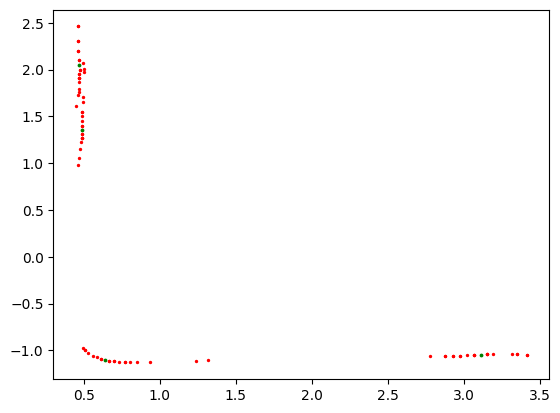

In [16]:
plt.plot(figsize=(10,5))
for i in range(len(d["state"])): 
    plt.scatter(x=d["state"][i][0][0], y=d["state"][i][0][1], s=3, c="green")
    for j in range(num_neighbours): 
        plt.scatter(x=neighbours[i][j][0], y = neighbours[i][j][1], s=2, c="red")

plt.show()

In [17]:
states = [] 

for i in range(len(d["state"])): 
    states.append(d["state"][i][0])
    for j in range(num_neighbours): 
        states.append(neighbours[i][j])
tensor_states = torch.as_tensor(states, dtype=torch.float32)

In [18]:
# Project into high dimensional space 
with torch.no_grad(): 
    z = cl_model(tensor_states)

In [19]:
beta = torch.as_tensor(35, dtype=torch.float32)

# mhn clusters 
U = cmhn.run(z, z, beta=beta, run_as_batch=True)

U.size() 

torch.Size([84, 32])

In [22]:
unique_U = remove_dupes(U, k=1000, threshold=0.95)
unique_U.size()

torch.Size([9, 32])

In [23]:
pca = PCA(n_components=2) 

points = pca.fit_transform(unique_U)
points

array([[ 0.50170769,  0.03463245],
       [ 0.51509052, -0.00242014],
       [-0.40191988,  0.46249272],
       [-0.29224566, -0.01932391],
       [-0.3230329 ,  0.29071797],
       [-0.28882384, -0.40059896],
       [-0.44935495, -0.33781233],
       [ 0.39077599,  0.00349312],
       [ 0.34780304, -0.03118091]])

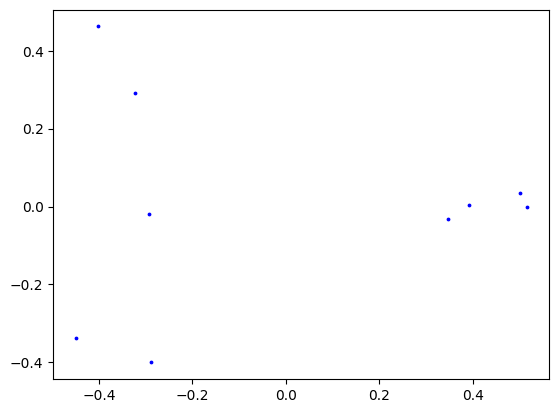

In [24]:
plt.plot(figsize=(10,6))
for i in range(len(points)): 
    plt.scatter(x=points[i][0], y= points[i][1], s=3, c= "blue")

plt.show()